In [1]:
%matplotlib inline

import os

import torch
import gpytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap.umap_ as umap
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from botorch.models.gpytorch import GPyTorchModel
from botorch.fit import fit_gpytorch_model
from botorch.utils.transforms import standardize, normalize, unnormalize
from botorch.acquisition import ExpectedImprovement, UpperConfidenceBound, ProbabilityOfImprovement
from scipy import linalg
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import PathToSubmol, FindAtomEnvironmentOfRadiusN, MolToSmiles
from rdkit.Chem.AtomPairs import Pairs
from MDAnalysis.analysis.rms import rmsd
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from map4 import MAP4Calculator

### Summary:
    * Load dataset (HLA-A°02:01, 9 mers only)
    * Correlation between PSSM and exp.values - r2 0.644 - RMSD 1.189
    * Baye opt.
        * Generate 150 random 9-mers peptides with affinity binding between 1 and 250 uM (-8.2/-5 kcal/mol)
        * Opt loop:
            * Exp 1:
                1. Train GP model on the training set (MAP4 4096 + Tanimoto kernel)
                2. Use PBIL to maximize probability of improvement acquisition function
                3. Pick 96 peptides with the highest probability of improvement values
                4. Get their real affinity binding values (linear regression model, > -5 kcal/mol no binding)
                5. Add the 96 selected candidates to the training dataset
                6. GOTO 1, until 3 generations
            * Exp 2:
                * Same as Exp. 1, but use PCA descriptors + RBF kernel

## Read dataset

In [2]:
mhci = pd.read_csv('binding_data_2013/bdata.20130222.mhci.csv')

In [3]:
# We removed those binding affinity values
# A lot of peptides were set with those values. Looks like some default values assigned...
dirty_values = [1, 2, 3, 5000, 10000, 20000, 43424, 50000, 69444.44444, 78125]

# Split dataset in training and testing sets
mhci = mhci[(mhci['mhc_allele'] == 'HLA-A*02:01') &
            (mhci['length'] == 9) &
            (~mhci['affinity_binding'].isin(dirty_values))]

In [4]:
data = []
AA = []

with open('IEDB_MHC_I-2.9_matx_smm_smmpmbec/smm_matrix/HLA-A-02:01-9.txt') as f:
    lines = f.readlines()
    
    for line in lines[1:-1]:
        sline = line.strip().split('\t')
        AA.append(sline[0])
        data.append([float(v) for v in sline[1:]])

columns = list(range(1, 10))
pssm = pd.DataFrame(data=data, columns=columns, index=AA)

## Correlation between PSSM and exp. values

In [5]:
pssm_scores = []

for peptide in mhci.itertuples():
    score = 0
    
    for i, aa in enumerate(peptide.sequence):
        score += pssm.loc[aa][i + 1]
    
    pssm_scores.append(score)
    
pssm_scores = np.array(pssm_scores)

R2: 0.644
RMSD : 1.189 kcal/mol


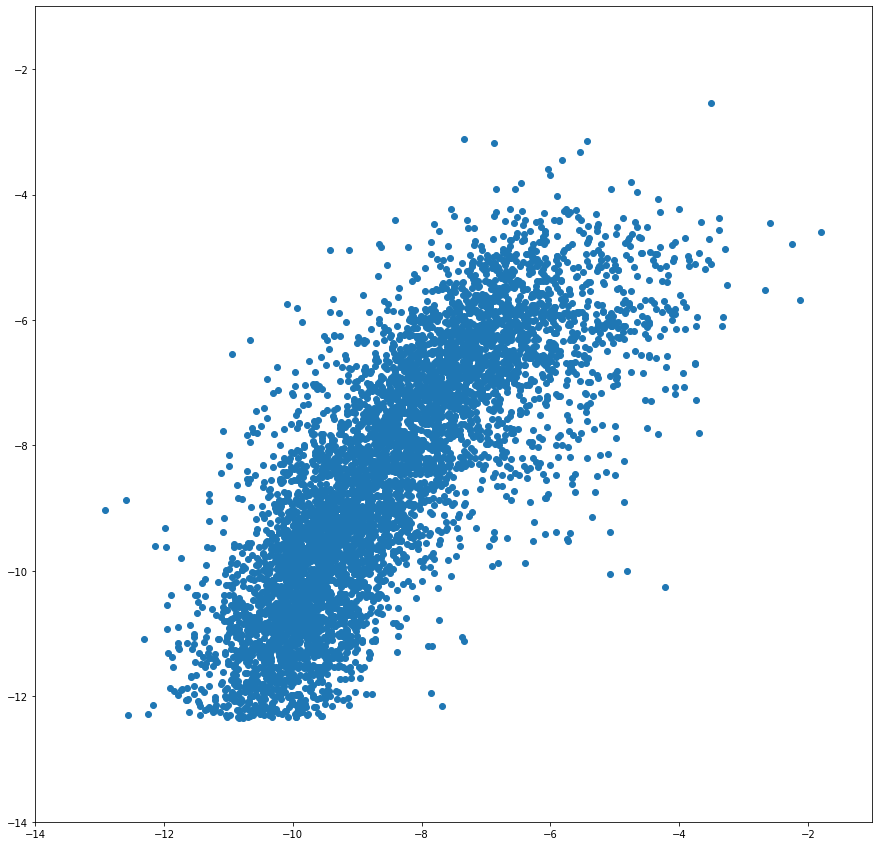

In [68]:
# Fit PSSM score to exp. values
reg = LinearRegression()
reg.fit(pssm_scores[:,None], mhci['energy'])
print('R2: %.3f' % reg.score(pssm_scores[:,None], mhci['energy']))
print('RMSD : %.3f kcal/mol' % rmsd(reg.predict(pssm_scores[:,None]), mhci['energy']))

fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(reg.predict(pssm_scores[:,None]), mhci['energy'])
ax.set_xlim([-14, -1])
ax.set_ylim([-14, -1])
plt.show()

In [46]:
temperature = 300.
RT = 0.001987 * temperature
RT * np.log(500 * 1e-9)

-8.648610877934287

## Bayesian opt.

In [9]:
class TanimotoSimilarityKernel(gpytorch.kernels.Kernel):
    # the sequence kernel is stationary
    is_stationary = True     

    # this is the kernel function
    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        if last_dim_is_batch:
            # Not tested
            x1 = x1.transpose(-1, -2).unsqueeze(-1)
            x2 = x2.transpose(-1, -2).unsqueeze(-1)

        x1_eq_x2 = torch.equal(x1, x2)
        
        x1s = torch.sum(torch.square(x1), dim=-1)
        x2s = torch.sum(torch.square(x2), dim=-1)
        
        if diag:
            if x1_eq_x2:
                res = torch.ones(*x1.shape[:-2], x1.shape[-2], dtype=x1.dtype, device=x1.device)
                return res
            else:
                product = torch.mul(x1, x2).sum(dim=1)
                denominator = torch.add(x2s, x1s) - product
        else:
            product = torch.mm(x1, x2.transpose(1, 0))
            denominator = torch.add(x2s, x1s[:, None]) - product

        res = product / denominator
        
        return res

    
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP, GPyTorchModel):
    # to inform GPyTorchModel API
    _num_outputs = 1
    
    def __init__(self, train_x, train_y, likelihood, kernel=None):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        if kernel is not None:
            self.covar_module = gpytorch.kernels.ScaleKernel(kernel())
        else:
            self.covar_module = gpytorch.kernels.ScaleKernel(TanimotoSimilarityKernel())

        # make sure we're on the right device/dtype
        self.to(train_x)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    
def get_fitted_model(train_x, train_y, state_dict=None, kernel=None):
    # initialize and fit model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood, kernel)
    
    if state_dict is not None:
        model.load_state_dict(state_dict)
    
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
    mll.to(train_x)
    
    # Train model!
    fit_gpytorch_model(mll)
    
    return model

In [10]:
def predict(model, likelihood, test_x):
    model.eval()
    likelihood.eval()
    
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Test points are regularly spaced along [0,1]
        return likelihood(model(test_x))


def plot(y_test, observed_pred, fig_filename=None):
    with torch.no_grad():
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        
        ax.scatter(y_test, observed_pred)
        
        ax.set_xlim([np.min([y_test, observed_pred]) - 1, np.max([y_test, observed_pred]) + 1])
        ax.set_ylim([np.min([y_test, observed_pred]) - 1, np.max([y_test, observed_pred]) + 1])
        ax.set_xlabel('Experimental values (kcal/mol)', fontsize=20)
        ax.set_ylabel('Predicted values (kcal/mol)', fontsize=20)
        
        if fig_filename is not None:
            plt.savefig(fig_filename, bbox_inches='tight', dpi=300)
        
        plt.show()

In [11]:
def expected_improvement(model, Y_train, Xsamples, greater_is_better=False, xi=0.00):
    """ expected_improvement
    Expected improvement acquisition function.
    
    Source: https://github.com/thuijskens/bayesian-optimization/blob/master/python/gp.py
    
    Arguments:
    ----------
        model: Gaussian process model
        Y_train: Array that contains all the observed energy interaction seed so far
        X_samples: Samples we want to try out
        greater_is_better: Indicates whether the loss function is to be maximised or minimised.
        xi: Exploitation-exploration trade-off parameter

    """
    # calculate mean and stdev via surrogate function
    observed_pred = predict(model, model.likelihood, Xsamples)
    sigma = observed_pred.variance.sqrt().detach().numpy()
    mu = observed_pred.mean.detach().numpy()

    if greater_is_better:
        loss_optimum = np.max(Y_train.numpy())
    else:
        loss_optimum = np.min(Y_train.numpy())

    scaling_factor = (-1) ** (not greater_is_better)

    # calculate the expected improvement
    Z = scaling_factor * (mu - loss_optimum - xi) / (sigma + 1E-9)
    ei = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + (sigma * norm.pdf(Z))
    ei[sigma == 0.0] == 0.0

    return -1 * ei


# probability of improvement acquisition function
def probability_of_improvement(model, Y_train, Xsamples, greater_is_better=False):
    """ probability_of_improvement
    Probability of improvement acquisition function.
        
    Arguments:
    ----------
        model: Gaussian process model
        Y_train: Array that contains all the observed energy interaction seed so far
        X_samples: Samples we want to try out
        greater_is_better: Indicates whether the loss function is to be maximised or minimised.

    """
    # calculate mean and stdev via surrogate function
    observed_pred = predict(model, model.likelihood, Xsamples)
    sigma = observed_pred.variance.sqrt().detach().numpy()
    mu = observed_pred.mean.detach().numpy()
    
    if greater_is_better:
        loss_optimum = np.max(Y_train.numpy())
    else:
        loss_optimum = np.min(Y_train.numpy())

    scaling_factor = (-1) ** (not greater_is_better)
    
    # calculate the probability of improvement
    Z = scaling_factor * (mu - loss_optimum) / (sigma + 1E-9)
    pi = norm.cdf(Z)
    pi[sigma == 0.0] == 0.0
    
    return pi

In [119]:
def score_peptides(sequences, pssm, reg, cutoff=-5.0):
    scores = []
    
    for sequence in sequences:
        score = 0
        
        for i, aa in enumerate(sequence):
            score += pssm.loc[aa][i + 1]
        
        scores.append(score)
    
    pred_scores = reg.predict(np.array(scores)[:,None])
    pred_scores[pred_scores > cutoff] = 0.
    
    return pred_scores

In [232]:
def find_next_candidates(model, acq_fun, y_exp):
    NGEN = 10
    NIND = 250
    NBEST = 50
    NLEN = 9
    NCAN = 96

    #Initialize the PBIL EDA
    pbil = PBIL(model, acq_fun, y_exp, peptide_length=NLEN, population_size=NIND, n_best=NBEST)

    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)
    #creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    #creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("evaluate", pbil.evaluate)
    toolbox.register("generate", pbil.generate, creator.Individual)
    toolbox.register("update", pbil.update)

    # Statistics computation
    hof = tools.HallOfFame(NCAN)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop, logbook = algorithms.eaGenerateUpdate(toolbox, NGEN, stats=stats, verbose=True, halloffame=hof)

    #plot_logbook(logbook, minimum_score)
    
    candidates = [''.join(s) for s in hof.items]

    return candidates, hof

## MAP4 fingerprint + tanimoto kernel

In [212]:
def map4_fingerprint(sequences, dimensions=4096, radius=2, is_counted=False, is_folded=True):
    MAP4_unf = MAP4Calculator(dimensions=dimensions, radius=radius, is_counted=is_counted, is_folded=is_folded)
    fps = MAP4_unf.calculate_many([Chem.rdmolfiles.MolFromFASTA(s) for s in sequences])
    return torch.from_numpy(np.array(fps)).float()

In [223]:
class PBIL(object):
    def __init__(self, model, acq_fun, y_exp, peptide_length=9, population_size=96, n_best=48,
                 learning_rate=0.5, mut_prob=0.0, mut_shift=0.00, seed=None):
        self._AA1 = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I',
                     'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
        self._model = model
        self._acq_fun = acq_fun
        self._y_exp = y_exp
        
        # Random generation
        self._random_seed = seed
        self._rng = np.random.default_rng(self._random_seed)

        # Initialize probability vectors
        n_amino_acids = len(self._AA1)
        self._peptide_length = peptide_length
        init_probability = 1. / n_amino_acids
        self._prob_vector = np.zeros(shape=(peptide_length, n_amino_acids)) + init_probability

        # PBIL parameters
        self._n_best = n_best
        self._learning_rate = learning_rate
        self._mut_prob = mut_prob
        self._mut_shift = mut_shift
        self._population_size = population_size
        
        # Elitism
        self._best_score = 0.
        #self._best_score = 999.

    def sample(self):
        ind = [self._rng.choice(self._AA1, p=self._prob_vector[i]) for i in range(self._peptide_length)]
        return (ind)
    
    def evaluate(self, individual):
        MAP4_unf = MAP4Calculator(dimensions=4096, radius=2, is_counted=False, is_folded=True)
        fps = MAP4_unf.calculate(Chem.rdmolfiles.MolFromFASTA(''.join(individual)))
        individual = torch.from_numpy(np.array(fps)).float()[None,:]
        return self._acq_fun(self._model, self._y_exp, individual)[0],
    
    def generate(self, ind_init):
        return [ind_init(self.sample()) for _ in range(self._population_size)]

    def update(self, population, scores=None):
        if scores is None:
            scores = np.array([ind.fitness.values[0] for ind in population])

        best_peptide_indices = np.argsort(np.ravel(scores))[::-1][:self._n_best]
        #best_peptide_indices = np.argsort(np.ravel(scores))[:self._n_best]
        
        best_peptides = np.array(population)[best_peptide_indices]
        
        for i in range(self._peptide_length):
            if self._n_best > 1:
                if scores[best_peptide_indices[0]] > self._best_score:
                #if scores[best_peptide_indices[0]] < self._best_score:
                    self._best_score = scores[best_peptide_indices[0]]
                
                weights = np.array([1] * len(best_peptides[:,i]))
                
                # Inverse the order
                # For this position, put the best peptide at the end
                # When updating the probability vector, the last one has more impact 
                # then the first sequence
                amino_acids = np.flip(best_peptides[:,i])
                
            else:
                # When we choose only one best peptide for updating the probability vector
                amino_acids = [best_peptides[0][i]]
                weights = [1.]
            
            for amino_acid, weight in zip(amino_acids, weights):
                j = self._AA1.index(amino_acid)
                
                # Update the probability vector
                self._prob_vector[i, j] *= 1.0 - self._learning_rate
                self._prob_vector[i, j] += weight * self._learning_rate

                # Mutate the probability vector
                if self._rng.uniform() < self._mut_prob:
                    self._prob_vector[i, j] *= 1.0 - self._mut_shift
                    self._prob_vector[i, j] += self._rng.uniform() * self._mut_shift
            
            # Normalize vector
            self._prob_vector[i] /= np.sum(self._prob_vector[i])

In [237]:
random_peptides = []
random_peptide_scores = []
energy_cutoff = -5 # around 250 uM

while True:
    p = ''.join(np.random.choice(pssm.index, 9))
    s = score_peptides([p], pssm, reg, cutoff=energy_cutoff)[0]
    
    # about between 1 and 250 uM
    if -8.2 <= s <= -5:
        random_peptides.append(p)
        random_peptide_scores.append(s)
    
    if len(random_peptides) == 150:
        break
        
random_peptides = np.array(random_peptides)
random_peptide_scores = np.array(random_peptide_scores)

In [238]:
# Compute the MAP4 fingerprint for all the peptides
X_fps_exp = map4_fingerprint(random_peptides)
y_exp = torch.from_numpy(random_peptide_scores).float()

print('Exp dataset size: (%d, %d)' % (X_fps_exp.shape[0], X_fps_exp.shape[1]))

Exp dataset size: (150, 4096)


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


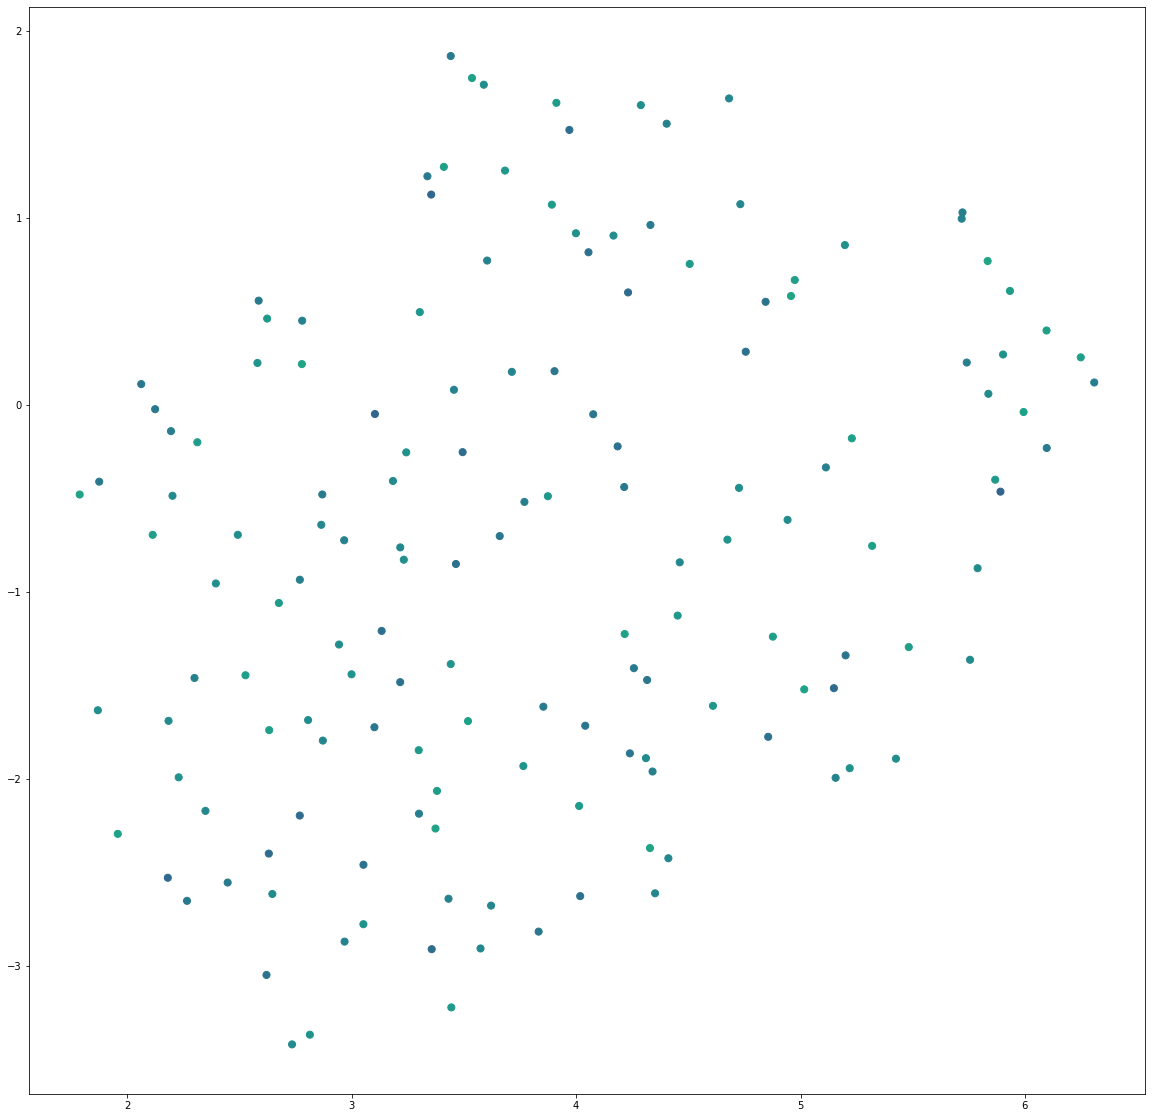

In [239]:
k = TanimotoSimilarityKernel()
mat = 1. - k.forward(X_fps_exp, X_fps_exp)

fit = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='precomputed')
u = fit.fit_transform(mat)

fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(u[:,0], u[:,1], s=50, c=y_exp.numpy(), vmin=-12, vmax=0)
plt.show()

Init.
N pep:  150
Best peptide: -8.196
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 045
N pep under -6 kcal/mol: 098
N pep under -5 kcal/mol: 150
Non binding pep        : 000



Generation: 1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg      	std      	min        	max     
0  	250   	0.0121141	0.0165131	0.000221067	0.108698
1  	250   	0.0253003	0.0288059	0.000268188	0.241752
2  	250   	0.0439378	0.0395416	0.00102533 	0.255098
3  	250   	0.0583122	0.0393494	0.00344925 	0.303085
4  	250   	0.064907 	0.0451028	0.0026391  	0.229621
5  	250   	0.0806773	0.0502124	0.00628606 	0.314727
6  	250   	0.0863145	0.0534148	0.0071323  	0.306521
7  	250   	0.0945223	0.0521335	0.009542   	0.273093
8  	250   	0.0946792	0.0498321	0.00740448 	0.239998
9  	250   	0.0951697	0.0565463	0.00442377 	0.319863

N pep:  246
Best peptide: -11.579
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 004
N pep under -10 kcal/mol: 013
N pep under -9 kcal/mol: 035
N pep under -8 kcal/mol: 073
N pep under -7 kcal/mol: 133
N pep under -6 kcal/mol: 191
N pep under -5 kcal/mol: 246
Non binding pep        : 000


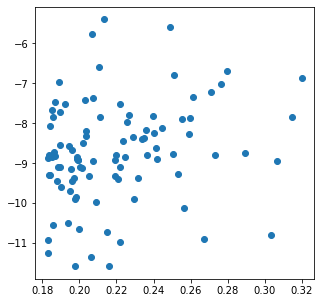




Generation: 2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std        	min        	max        
0  	250   	9.77837e-06	7.39062e-05	1.88779e-12	0.000795729
1  	250   	1.76293e-05	0.000113412	4.4933e-11 	0.00153331 
2  	250   	3.09975e-05	0.000216156	1.53857e-12	0.00316802 
3  	250   	8.50914e-05	0.00052702 	1.44941e-10	0.00776395 
4  	250   	0.000156941	0.000679764	2.09506e-09	0.00841407 
5  	250   	0.000400461	0.00135494 	8.01618e-11	0.0136991  
6  	250   	0.000299798	0.00110736 	9.67722e-08	0.0142348  
7  	250   	0.000562786	0.00174067 	4.80345e-08	0.0140946  
8  	250   	0.000956151	0.00616887 	3.04168e-07	0.0955033  
9  	250   	0.00100847 	0.00285522 	2.4464e-07 	0.0280336  

N pep:  342
Best peptide: -12.333
N pep under -12 kcal/mol: 003
N pep under -11 kcal/mol: 023
N pep under -10 kcal/mol: 068
N pep under -9 kcal/mol: 121
N pep under -8 kcal/mol: 167
N pep under -7 kcal/mol: 229
N pep under -6 kcal/mol: 287
N pep under -5 kcal/mol: 342
Non binding pep        : 000


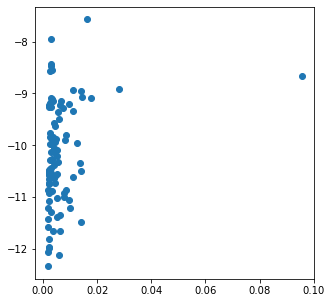




Generation: 3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg        	std        	min        	max        
0  	250   	1.78488e-07	1.59149e-06	8.50009e-16	2.41213e-05
1  	250   	7.12538e-06	9.15792e-05	7.68684e-15	0.00144835 
2  	250   	9.09476e-06	6.21269e-05	3.09e-15   	0.000731536
3  	250   	0.000316805	0.0029732  	1.33187e-12	0.0419481  
4  	250   	0.000108731	0.000632008	8.8851e-11 	0.00690035 
5  	250   	0.000240127	0.00129271 	3.67183e-11	0.0141698  
6  	250   	0.000635046	0.00362408 	4.41519e-10	0.05012    
7  	250   	0.000658783	0.00370164 	7.38527e-10	0.0561215  
8  	250   	0.000657954	0.00233495 	4.44145e-10	0.023827   
9  	250   	0.001211   	0.0038114  	1.3893e-09 	0.0247737  

N pep:  438
Best peptide: -12.762
N pep under -12 kcal/mol: 009
N pep under -11 kcal/mol: 055
N pep under -10 kcal/mol: 152
N pep under -9 kcal/mol: 217
N pep under -8 kcal/mol: 263
N pep under -7 kcal/mol: 325
N pep under -6 kcal/mol: 383
N pep under -5 kcal/mol: 438
Non binding pep        : 000


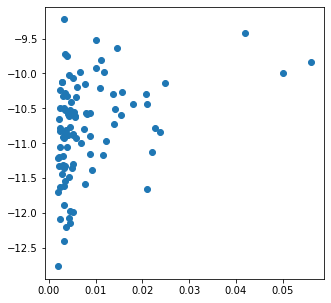

In [240]:
print('Init.')
print('N pep: ', X_fps_exp.shape[0])
print('Best peptide: %.3f' % y_exp.min())
for n in [-12, -11, -10, -9, -8, -7, -6, -5]:
    print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
print('Non binding pep        : %03d' % (y_exp[y_exp == 0.].shape[0]))
print('\n\n')

for i in range(3):
    print('Generation: %d' % (i + 1))
    # Train GP model
    model = get_fitted_model(X_fps_exp, y_exp, kernel=TanimotoSimilarityKernel)
    
    # Find new candidates
    candidates, hof = find_next_candidates(model, probability_of_improvement, y_exp)
    #candidates, hof = find_next_candidates(model, expected_improvement, y_exp)
    
    # Add candidates to the training set
    candidate_fps = map4_fingerprint(candidates)
    y_candidates = torch.from_numpy(np.array(score_peptides(candidates, pssm, reg)))
    
    X_fps_exp = torch.cat([X_fps_exp, candidate_fps])
    y_exp = torch.cat([y_exp, y_candidates])
    
    print('')
    print('N pep: ', X_fps_exp.shape[0])
    print('Best peptide: %.3f' % y_exp.min())
    for n in [-12, -11, -10, -9, -8,  -7, -6, -5]:
        print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
    print('Non binding pep        : %03d' % (y_exp[y_exp == 0.].shape[0]))
    
    ei = np.array([k.values[0] for k in hof.keys])
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(ei, y_candidates.numpy())
    plt.show()
    
    print('\n\n')

## PCA descriptors + RBF kernel

In [127]:
def transform(sequences, scale):    
    transformed = []
    
    for seq in sequences:
        tmp = []

        for aa in seq:
            tmp.extend(scale[scale['AA1'] == aa].values[0][2:])

        transformed.append(tmp)
        
    return torch.from_numpy(np.array(transformed)).float()

In [128]:
class PBIL(object):
    def __init__(self, model, acq_fun, y_exp, peptide_length=9, population_size=96,
                 n_best=48, learning_rate=0.5, sigma=0.25, mut_prob=0.0, mut_shift=0.00,
                 seed=None):
        self._AA1 = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I',
                     'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
        self._model = model
        self._acq_fun = acq_fun
        self._y_exp = y_exp
        self._descriptors = pd.read_csv('pca.csv')
        
        # Random generation
        self._random_seed = seed
        self._rng = np.random.default_rng(self._random_seed)

        # Initialize probability vectors
        n_amino_acids = len(self._AA1)
        self._peptide_length = peptide_length
        init_probability = 1. / n_amino_acids
        self._prob_vector = np.zeros(shape=(peptide_length, n_amino_acids)) + init_probability

        # PBIL parameters
        self._sigma = sigma
        self._n_best = n_best
        self._learning_rate = learning_rate
        self._mut_prob = mut_prob
        self._mut_shift = mut_shift
        self._population_size = population_size
        
        # Elitism
        self._best_score = 0.

    def sample(self):
        ind = [self._rng.choice(self._AA1, p=self._prob_vector[i]) for i in range(self._peptide_length)]
        return (ind)
    
    def evaluate(self, individual):
        individual = transform([''.join(individual)], self._descriptors)
        return self._acq_fun(self._model, self._y_exp, individual)[0],
    
    def generate(self, ind_init):
        return [ind_init(self.sample()) for _ in range(self._population_size)]

    def update(self, population, scores=None):
        if scores is None:
            scores = np.array([ind.fitness.values[0] for ind in population])

        best_peptide_indices = np.argsort(np.ravel(scores))[::-1][:self._n_best]
        best_peptides = np.array(population)[best_peptide_indices]
        
        for i in range(self._peptide_length):
            if self._n_best > 1:
                if scores[best_peptide_indices[0]] > self._best_score:
                    self._best_score = scores[best_peptide_indices[0]]
                
                weights = np.array([1] * len(best_peptides[:,i]))
                
                # Inverse the order
                # For this position, put the best peptide at the end
                # When updating the probability vector, the last one has more impact 
                # then the first sequence
                amino_acids = np.flip(best_peptides[:,i])
                
            else:
                # When we choose only one best peptide for updating the probability vector
                amino_acids = [best_peptides[0][i]]
                weights = [1.]
            
            for amino_acid, weight in zip(amino_acids, weights):
                j = self._AA1.index(amino_acid)
                
                # Update the probability vector
                self._prob_vector[i, j] *= 1.0 - self._learning_rate
                self._prob_vector[i, j] += weight * self._learning_rate

                # Mutate the probability vector
                if self._rng.uniform() < self._mut_prob:
                    self._prob_vector[i, j] *= 1.0 - self._mut_shift
                    self._prob_vector[i, j] += self._rng.uniform() * self._mut_shift
            
            # Normalize vector
            self._prob_vector[i] /= np.sum(self._prob_vector[i])

In [129]:
random_peptides = []
random_peptide_scores = []
energy_cutoff = -5 # around 250 uM

while True:
    p = ''.join(np.random.choice(pssm.index, 9))
    s = score_peptides([p], pssm, reg, cutoff=energy_cutoff)[0]
    
    # about between 1 and 250 uM
    if -8.2 <= s <= -5:
        random_peptides.append(p)
        random_peptide_scores.append(s)
    
    if len(random_peptides) == 150:
        break
        
random_peptides = np.array(random_peptides)
random_peptide_scores = np.array(random_peptide_scores)

In [130]:
descriptors = pd.read_csv('pca.csv')

# Compute the MAP4 fingerprint for all the peptides
X_fps_exp = transform(random_peptides, descriptors)
y_exp = torch.from_numpy(random_peptide_scores).float()

print('Exp dataset size: (%d, %d)' % (X_fps_exp.shape[0], X_fps_exp.shape[1]))

Exp dataset size: (150, 45)


In [131]:
print('Init.')
print('N pep: ', X_fps_exp.shape[0])
print('Best peptide: %.3f' % y_exp.min())
for n in [-12, -11, -10, -9, -8, -7, -6, -5]:
    print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
print('Non binding pep               : %03d' % (y_exp[y_exp == 0.].shape[0]))
    
print('\n\n')


for i in range(3):
    print(i + 1)
    model = get_fitted_model(X_fps_exp, y_exp, kernel=gpytorch.kernels.RBFKernel)
    
    candidates = find_next_candidates(model, probability_of_improvement, y_exp)
    
    candidate_fps = transform(candidates, descriptors)
    y_candidates = torch.from_numpy(np.array(score_peptides(candidates, pssm, reg)))
    
    X_fps_exp = torch.cat([X_fps_exp, candidate_fps])
    y_exp = torch.cat([y_exp, y_candidates])
    
    print('N pep: ', X_fps_exp.shape[0])
    print('Best peptide: %.3f' % y_exp.min())
    for n in [-12, -11, -10, -9, -8, -7, -6, -5]:
        print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
    print('Non binding pep               : %03d' % (y_exp[y_exp == 0.].shape[0]))
    
    print('\n\n')

Init.
N pep:  150
Best peptide: -8.112
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 002
N pep under -7 kcal/mol: 042
N pep under -6 kcal/mol: 086
N pep under -5 kcal/mol: 150
Non binding pep               : 000



1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg      	std      	min       	max     
0  	200   	0.0239645	0.0307737	0.00020468	0.175917
1  	200   	0.0248692	0.0275026	7.49171e-05	0.15815 
2  	200   	0.0274738	0.0335938	0.000106567	0.234102
3  	200   	0.0290324	0.0339943	0.000358024	0.214832
4  	200   	0.0324291	0.0354223	7.8175e-05 	0.24182 
5  	200   	0.0343718	0.043377 	0.000288925	0.264186
6  	200   	0.0367766	0.0402694	0.000478787	0.296082
7  	200   	0.0335454	0.0395658	0.000375482	0.248231
8  	200   	0.0352119	0.0406458	0.000622162	0.319274
9  	200   	0.032231 	0.0304729	0.000231768	0.185532
N pep:  246
Best peptide: -9.181
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 001
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 045
N pep under -6 kcal/mol: 094
N pep under -5 kcal/mol: 177
Non binding pep               : 069



2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg      	std     	min       	max     
0  	200   	0.0777218	0.116274	5.2401e-05	0.759066
1  	200   	0.0860167	0.125719	5.14369e-06	0.590976
2  	200   	0.0867365	0.105672	6.65039e-05	0.531025
3  	200   	0.0880725	0.13195 	3.17548e-05	0.760149
4  	200   	0.0902391	0.122428	3.687e-05  	0.756777
5  	200   	0.101159 	0.114415	2.86231e-05	0.506394
6  	200   	0.120608 	0.15592 	5.85425e-05	0.89939 
7  	200   	0.120467 	0.158306	0.00022545 	0.706466
8  	200   	0.129176 	0.151235	8.76682e-05	0.718381
9  	200   	0.128453 	0.150051	0.000302735	0.915424
N pep:  342
Best peptide: -9.181
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 001
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 045
N pep under -6 kcal/mol: 094
N pep under -5 kcal/mol: 187
Non binding pep               : 155



3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg      	std    	min        	max     
0  	200   	0.0814374	0.14269	2.90607e-08	0.721294
1  	200   	0.0913561	0.158798	9.00004e-09	0.946706
2  	200   	0.0887291	0.149113	1.46858e-07	0.900749
3  	200   	0.0923049	0.160382	3.01911e-06	0.860495
4  	200   	0.103606 	0.168379	5.27337e-06	0.839545
5  	200   	0.0885194	0.136989	6.47051e-07	0.76584 
6  	200   	0.108478 	0.177206	7.77659e-09	0.820239
7  	200   	0.0955444	0.13169 	1.66089e-06	0.871476
8  	200   	0.126494 	0.175319	1.19975e-05	0.801391
9  	200   	0.156736 	0.210939	1.17974e-06	0.945413
N pep:  438
Best peptide: -9.181
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 001
N pep under -8 kcal/mol: 003
N pep under -7 kcal/mol: 045
N pep under -6 kcal/mol: 098
N pep under -5 kcal/mol: 202
Non binding pep               : 236



